In [1]:
!python --version
!pip install torchsummary

Python 3.10.14


In [2]:
import tensorflow as tf
import torch.nn as nn
from tensorflow.keras.datasets import mnist
import numpy as np
import cv2
import random
import torch
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torchsummary import summary
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.cluster import KMeans
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import torchvision
import matplotlib.patches as patches
from collections import Counter
from itertools import cycle
from sklearn.metrics import average_precision_score
from torchvision.ops import box_iou
from sklearn.metrics import average_precision_score
from collections import defaultdict
from sklearn.metrics import precision_recall_curve, auc

In [3]:
!cp /kaggle/input/pretrain-yolov3/yolov3_pretrain.pth /kaggle/working/
!cp /kaggle/input/myyolov3/yolov3DetectsDigits1.pth /kaggle/working

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


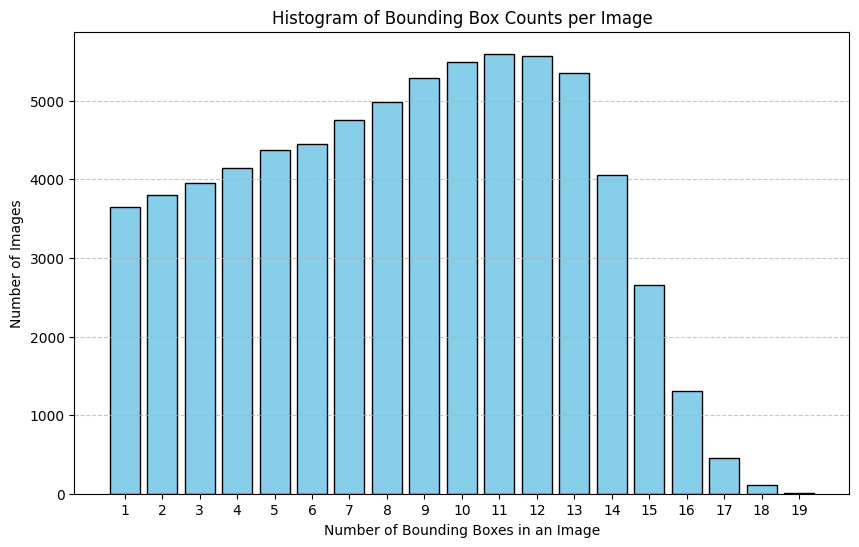

In [4]:
path_img = os.makedirs("yolo_data/images", exist_ok=True)
path_lb = os.makedirs("yolo_data/labels", exist_ok=True)

num_digits_cycle = cycle(range(1, 21))
def create_image_with_multiple_digits(img_size=160, obj_min_size=20, obj_max_size=40, max_iou=0.1):

    new_image = np.zeros((img_size, img_size), dtype=np.uint8)
    bounding_boxes = []
    labels = []

    num_digits = next(num_digits_cycle)
    len_x = len(x_train)
    for _ in range(num_digits):
        obj_size = random.randint(obj_min_size, obj_max_size)

        idx = random.randint(0, len_x - 1)
        digit_image = x_train[idx]
        label = y_train[idx]

        digit_image = cv2.resize(digit_image, (obj_size, obj_size))
        angle = random.uniform(-10, 10)
        # mat trận xoay quanh tâm ảnh  
        matrix = cv2.getRotationMatrix2D((obj_size / 2, obj_size / 2), angle, 1.0)
        digit_image = cv2.warpAffine(digit_image, matrix, (obj_size, obj_size))
        # RETR_EXTERNAL chỉ lấy đường bao bên ngoài cùng findContours tìm đường bao của các vùng sáng 
        # CHAIN_APPROX_SIMPLE chỉ lưu các điểm cần thiết 
        contours, _ = cv2.findContours(digit_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            x, y, w, h = cv2.boundingRect(contours[0])
        else:
            continue  # Nếu không tìm thấy contour, bỏ qua số này

        x_min = random.randint(0, img_size - w)
        y_min = random.randint(0, img_size - h)
        x_max, y_max = x_min + w, y_min + h

        # Kiểm tra IOU để tránh overlap quá lớn
        too_much_overlap = False
        for (existing_x_min, existing_y_min, existing_x_max, existing_y_max) in bounding_boxes:
            iou = calculate_iou((x_min, y_min, x_max, y_max), (existing_x_min, existing_y_min, existing_x_max, existing_y_max))
            if iou > max_iou:
                too_much_overlap = True
                break

        # Nếu không quá chồng lấn, thêm số vào ảnh
        if not too_much_overlap:
            new_image[y_min:y_max, x_min:x_max] = np.maximum(new_image[y_min:y_max, x_min:x_max], digit_image[y:y+h, x:x+w])

            bounding_boxes.append((x_min, y_min, x_max, y_max))
            labels.append((label, x_min, y_min, x_max, y_max))

    return new_image, labels

def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    iou = intersection / float(box1_area + box2_area - intersection)
    return iou

(x_train, y_train), (_, _) = mnist.load_data()
s_split = 10
img_size = 160
cell_pixels = img_size/s_split

box_counts = []
for idx in range(70000):  
    # Tạo ảnh và nhãn
    new_image, labels = create_image_with_multiple_digits()
    box_counts.append(len(labels))

    image_filename = f"yolo_data/images/{idx}.png"
    cv2.imwrite(image_filename, new_image)

    # Lưu nhãn theo định dạng YOLO
    label_filename = f"yolo_data/labels/{idx}.txt"
    with open(label_filename, "w") as f:
        for label, x_min, y_min, x_max, y_max in labels:
            x_center = (x_min + x_max) / 2 /img_size
            y_center = (y_min + y_max) / 2 /img_size
            width = (x_max - x_min) / img_size
            height = (y_max - y_min) / img_size
            f.write(f"{label} {x_center} {y_center} {width} {height}\n")

box_count_distribution = Counter(box_counts)

x_values = sorted(box_count_distribution.keys())  # Các số lượng bounding boxes
y_values = [box_count_distribution[x] for x in x_values]  # Số lượng ảnh tương ứng

plt.figure(figsize=(10, 6))
plt.bar(x_values, y_values, color='skyblue', edgecolor='black')
plt.xlabel("Number of Bounding Boxes in an Image")
plt.ylabel("Number of Images")
plt.title("Histogram of Bounding Box Counts per Image")
plt.xticks(x_values) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()           

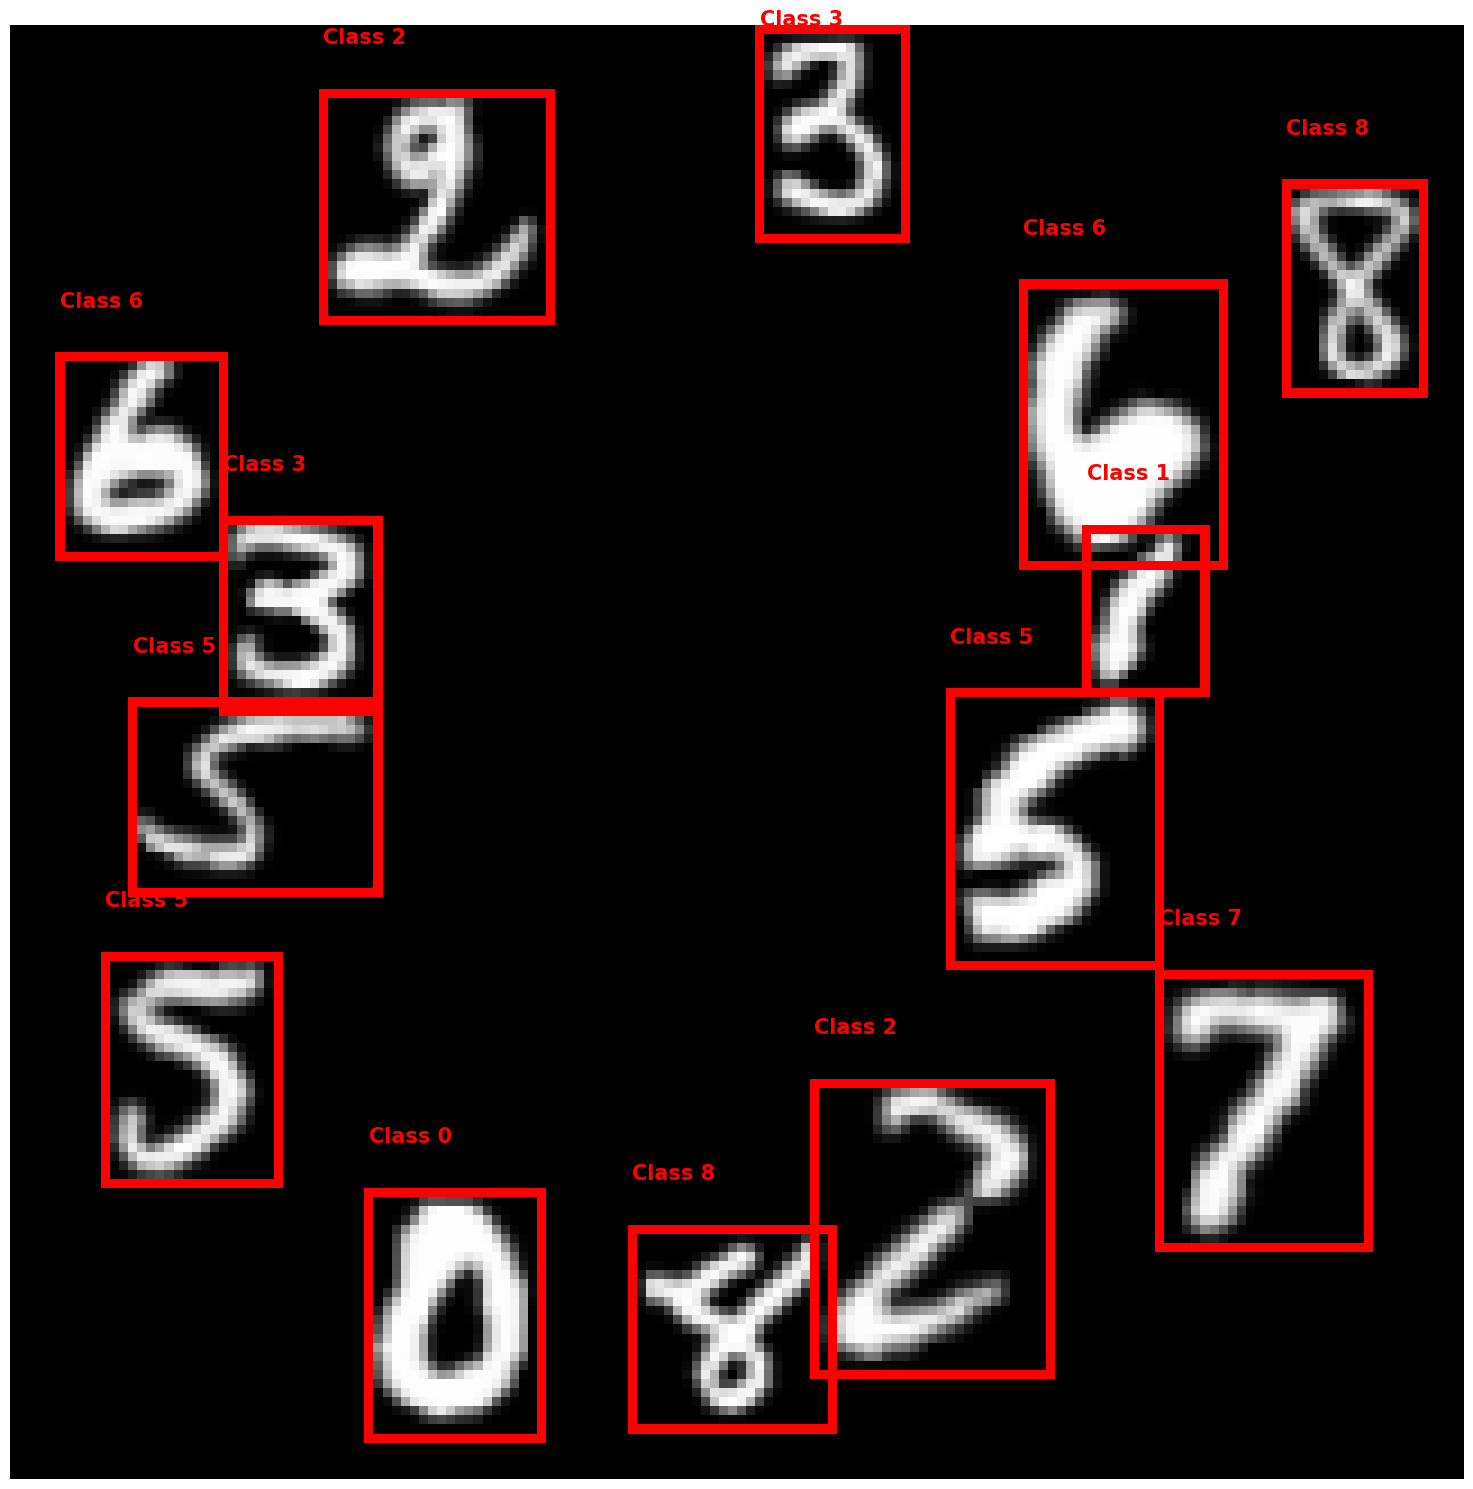

In [5]:
def load_and_display_images(num_images=20):
    idx = random.randint(0, 100)
    image_files = sorted(os.listdir("yolo_data/images"))[idx:idx+num_images]
    label_files = sorted(os.listdir("yolo_data/labels"))[idx:idx+num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))

    # If only one image is being displayed, axes is a single object, not an array.
    if num_images == 1:
        axes = [axes]

    for i, (image_file, label_file) in enumerate(zip(image_files, label_files)):
        img_path = os.path.join("yolo_data/images", image_file)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert to RGB for display

        label_path = os.path.join("yolo_data/labels", label_file)
        with open(label_path, "r") as f:
            for line in f:
                label_data = line.strip().split()
                class_id = int(label_data[0])
                x_center, y_center, width, height = map(float, label_data[1:])

                img_size = image.shape[0]
                x_center *= img_size
                y_center *= img_size
                width *= img_size
                height *= img_size

                x_min = int(x_center - width / 2)
                y_min = int(y_center - height / 2)
                x_max = int(x_center + width / 2)
                y_max = int(y_center + height / 2)

                # Draw the red bounding box using OpenCV
                color = (255, 0, 0)  # Red color for the bounding box
                thickness = 1
                image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)

                # Add the label using ax.text
                label_text = f"Class {class_id}"
                text_x = x_min
                text_y = y_min - 5  # Position the text above the bounding box

                # Make sure the label doesn't go outside the image
                if text_y < 0:
                    text_y = 0

                # Use ax.text to add the label
                axes[i].text(text_x, text_y, label_text, color="red", fontsize=15, ha="left", va="bottom", weight='bold')

        # Display the image using matplotlib
        axes[i].imshow(image)
        axes[i].axis('off')  # Hide axis labels

    plt.tight_layout()
    plt.show()

    
load_and_display_images(num_images=1)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


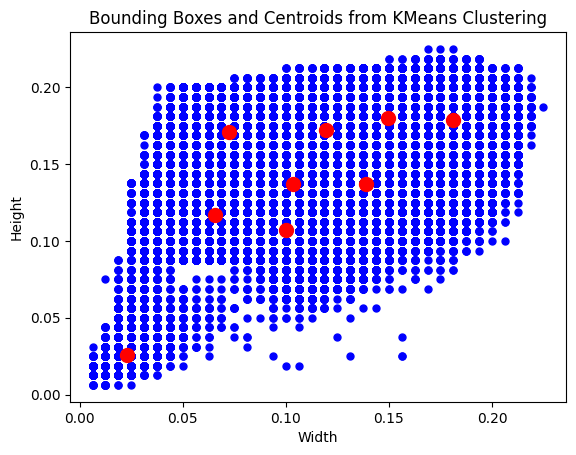

NameError: name 'plot_bounding_box_centroids' is not defined

In [6]:
def load_labels(label_folder):
    labels = []
    centerxy = []
    class_name = []
    for file_name in os.listdir(label_folder):
        if file_name.endswith(".txt"):
            with open(os.path.join(label_folder, file_name), 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    w, h = float(parts[3]), float(parts[4])
                    x, y = float(parts[1]), float(parts[2])
                    c = int(parts[0])
                    labels.append([w, h])
                    centerxy.append([x*160,y*160])
                    class_name.append(c)
                    
    return np.array(labels), np.array(centerxy),np.array(class_name)

def kmeans_anchors(labels, k=9):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(labels)

    return kmeans.cluster_centers_

def plot_bboxes_and_centroids(labels, centroids):
    fig, ax = plt.subplots()
    
    for label in labels:
        width, height = label
        ax.plot(width,height,'bo',markersize = 5)

    for centroid in centroids:
        ax.plot(centroid[0], centroid[1], 'ro', markersize=10)  
    
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.title("Bounding Boxes and Centroids from KMeans Clustering")
    plt.show()

# def plot_bounding_box_centroids(labels):
#     fig, ax = plt.subplots()
    
#     # Vẽ các tọa độ tâm của bounding boxes
#     for label in labels:
#         center_x, center_y = label
#         ax.plot(center_x, center_y, 'bo', markersize=3)  # Điểm màu xanh dương

#     plt.xlabel("Center X")  
#     plt.ylabel("Center Y") 
#     plt.title("Distribution of Bounding Box Centroids")  
#     plt.show() 

# def plot_class_distribution(class_name):

#     class_count = Counter(class_name)
#     plt.figure(figsize=(10, 6))
#     plt.bar(class_count.keys(), class_count.values(), color='skyblue', edgecolor='black')
#     plt.xlabel('Class')
#     plt.ylabel('Number of Ground Truth Boxes')
#     plt.title('Distribution of Ground Truth Boxes per Class')
#     plt.xticks(range(len(class_count)), class_count.keys())
#     plt.grid(axis='y', linestyle='--', alpha=0.7)
#     plt.show()
    

def classify_anchors(anchors):
    areas = anchors[:, 0] * anchors[:, 1]

    sorted_indices = np.argsort(areas)
    sorted_anchors = anchors[sorted_indices]

    num_anchors = len(sorted_anchors)
    group_size = num_anchors // 3

    large_anchors = sorted_anchors[:group_size]
    medium_anchors = sorted_anchors[group_size:2*group_size]  
    small_anchors = sorted_anchors[2*group_size:] 
    
    return large_anchors, medium_anchors, small_anchors

label_folder = "yolo_data/labels" 

labels, centerxy, class_name = load_labels(label_folder)

num_anchors = 9 
anchors = kmeans_anchors(labels, k=num_anchors)
plot_bboxes_and_centroids(labels,anchors)
plot_bounding_box_centroids(centerxy)
plot_class_distribution(class_name)
# Phân loại anchor boxes thành các nhóm lớn, trung bình và nhỏ
large_anchors, medium_anchors, small_anchors = classify_anchors(anchors)


In [ ]:
def iou_anchor(box1, box2):
    intersection = torch.min(box1[..., 0], box2[..., 0]) * torch.min(box1[..., 1], box2[..., 1])

    union = (box1[..., 0] * box1[..., 1]) + (box2[..., 0] * box2[..., 1]) - intersection

    return intersection / (union + 1e-6)  # Tránh chia cho 0


class YoloDataset(Dataset):
    def __init__(self, annotations, img_folder, label_folder, anchors, S=[5, 10, 20], C=10):
        self.img_folder = img_folder
        self.label_folder = label_folder
        self.annotations = annotations
        self.S = S
        self.anchors = torch.tensor(anchors)
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.C = C
        self.ignore_iou_thresh = 0.7

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_folder, f"{self.annotations[index]}.png")
        label_path = os.path.join(self.label_folder, f"{self.annotations[index]}.txt")

        # Đọc ảnh
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  
        image = torch.tensor(image, dtype=torch.float32) / 255.0 
        # Đọc nhãn
        bboxes = np.loadtxt(label_path, delimiter=" ").reshape(-1, 5)  # (class, x, y, w, h)

        # Khởi tạo targets cho từng scale
        targets = [torch.zeros((self.num_anchors // 3, S, S, 6)) for S in self.S]

        for box in bboxes:
            iou_anchors = iou_anchor(torch.tensor(box[3:5]), self.anchors)
            anchor_indices = iou_anchors.argsort(descending=True)

            class_label, x, y, width, height = box
            has_anchor = [False, False, False]

            for anchor_idx in anchor_indices:
                scale_idx = anchor_idx // self.num_anchors_per_scale
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale

                S = self.S[scale_idx]
                i, j = int(S * y), int(S * x)
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]

                if not anchor_taken and not has_anchor[scale_idx]:
                    x_cell, y_cell = S * x - j, S * y - i
                    width_cell, height_cell = width * S, height * S

                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = torch.tensor([x_cell, y_cell, width_cell, height_cell])
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
                    has_anchor[scale_idx] = True

        return image, targets

train_idx, test_idx = train_test_split([str(i) for i in range(70000)], test_size=0.2, random_state=42)
img_folder = "yolo_data/images"
label_folder = "yolo_data/labels"
anchors = []
anchors.extend(small_anchors.copy())
anchors.extend(medium_anchors.copy())
anchors.extend(large_anchors.copy())
anchors.sort(key= lambda x1:-x1[0]*x1[1])
normalized_anchors = np.array(anchors.copy())
normalized_anchors[0:3] *= 5
normalized_anchors[3:6] *= 10  
normalized_anchors[6:9] *= 20  


train_dataset = YoloDataset(train_idx, img_folder, label_folder, anchors)
dataLoader  = DataLoader(train_dataset,batch_size=4,shuffle=True,num_workers=2)
# _, _ =next(iter(dataLoader))
# Kiểm tra
for i in range(1):
    image, targets = train_dataset[i]
    print(f"Image {i} shape: {image.shape}")
    for scale_idx, target in enumerate(targets):
        print(f"Target at scale {scale_idx}: {target.dtype}")

In [ ]:
def visualize_targets(image, targets, anchors, S):
    # Convert image tensor to numpy array for visualization
    image = image.numpy()

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(image, cmap="gray")
    img_size = image.shape[1]

    colors = ["red", "blue", "yellow"]

    for scale_idx, (target, scale) in enumerate(zip(targets, S)):
        cell_size = img_size / scale  
        print(scale_idx, cell_size)
        for anchor in range(target.shape[0]): 
            # Find all active grid cells for this scale and anchor
            active_cells = torch.nonzero(target[anchor, :, :, 0] == 1, as_tuple=False)
            for cell in active_cells:
                i, j = cell  # Grid indices
                x_cell, y_cell, width_cell, height_cell = target[anchor, i, j, 1:5]
                # Convert to pixel coordinates
                x = (j + x_cell) * cell_size
                y = (i + y_cell) * cell_size
                w = width_cell * cell_size
                h = height_cell * cell_size

                # Draw bounding box (white)
                rect = patches.Rectangle(
                    (x - w / 2, y - h / 2), w, h,
                    linewidth=2, edgecolor="white", facecolor="none"
                )
                ax.add_patch(rect)

                # Draw anchor box (colored by scale)
                anchor_w, anchor_h = anchors[scale_idx * (len(anchors) // 3) + anchor]
  
                anchor_w *= cell_size
                anchor_h *= cell_size
                rect_anchor = patches.Rectangle(
                    (x - anchor_w / 2, y - anchor_h / 2), anchor_w, anchor_h,
                    linewidth=1, edgecolor=colors[scale_idx], linestyle="--", facecolor="none"
                )
                ax.add_patch(rect_anchor)

    plt.show()

# Lấy một ảnh và targets từ dataset
for i in range(4):
    idx = random.randint(0, 100)
    image, targets = train_dataset[idx]

    visualize_targets(image, targets, normalized_anchors, train_dataset.S)

In [ ]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act

    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)
            
class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats= 1):
        super().__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_repeats):
            self.layers += [
                nn.Sequential
                (CNNBlock(channels, channels//2, kernel_size =1),
                CNNBlock(channels//2, channels, kernel_size =3, padding =1)),
            ]
        self.use_residual = use_residual
        self.num_repeats = num_repeats
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x) + x if self.use_residual else layer(x)
        return x

class ScalePrediction(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2*in_channels, kernel_size=3, padding=1),
            CNNBlock(2*in_channels, (num_classes + 5)*3, bn_act=False, kernel_size=1)
        ) 
        self.num_classes = num_classes
        
    def forward(self, x):
        return (self.pred(x)
                .reshape(x.shape[0], 3, self.num_classes + 5, x.shape[2], x.shape[3])
                .permute(0, 1, 3, 4, 2))

In [ ]:
class Yolov3Pretrain(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.layers = self._create_conv_layers()

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * 3 * 3, 512),  # 1024 là số lượng kênh sau khi qua các lớp CNN
            nn.ReLU(),
            nn.Linear(512, self.num_classes),
        )
        
        self._initialize_weights()

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.fc(x)

    def _create_conv_layers(self):
        config = [
            (32, 3, 1),
            (64, 3, 2),
            ["B", 1],
            (128, 3, 2),
            ["B", 2],
            (256, 3, 2),
            ["B", 8],
            (512, 3, 2),
            ["B", 8],
            (1024, 3, 2),
            ["B", 4],  # Đến đây là Darknet-53
        ]
        layers = nn.ModuleList()
        in_channels = self.in_channels
        
        for module in config:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0 
                    )
                )
                in_channels = out_channels
                
            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(ResidualBlock(in_channels, num_repeats=num_repeats))
                
        return layers

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def train_model(self, train_dataset, optimizer, lossf, batch_size, num_epochs,device):
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        for epoch in range(num_epochs):
            self.train()
            running_loss  = 0.0
            for inputs,labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = self(inputs)
                loss = lossf(outputs,labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    def test_model(self, test_loader, device, num_images=5):
        self.eval() 
        with torch.no_grad(): 
            data_iter = iter(test_loader) 
            for _ in range(num_images): 
                inputs, labels = next(data_iter) 
               
                idx = random.randint(0, len(inputs) - 1)
                img = inputs[idx].cpu().numpy() 
                label = labels[idx].item()  
                
              
                img_tensor = inputs[idx].unsqueeze(0).to(device)  #  thêm batch dimension
                output = self(img_tensor)
                _, predicted = torch.max(output, 1)  
    
                plt.imshow(np.squeeze(img), cmap='gray') 
                plt.title(f"Predicted: {predicted.item()}, True Label: {label}")
                plt.show()
                

class RandomResizeAndPlacementTransform:
    def __init__(self, canvas_size=32, min_image_size=20, max_image_size=40):
        self.canvas_size = canvas_size
        self.min_image_size = min_image_size
        self.max_image_size = max_image_size

    def __call__(self, img):
        canvas = torch.zeros(1, self.canvas_size, self.canvas_size)
        
        image_size = random.randint(self.min_image_size, self.max_image_size)

        resize_transform = transforms.Resize((image_size, image_size))
        img_resized = resize_transform(img)

        img_tensor = transforms.ToTensor()(img_resized)

        offset_range = self.canvas_size - image_size
        top = random.randint(0, offset_range)
        left = random.randint(0, offset_range)

        # Đặt ảnh vào canvas
        canvas[:, top:top+image_size, left:left+image_size] = img_tensor
        return canvas

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pretrain = Yolov3Pretrain(in_channels = 1, num_classes  = 10) .to(device)
summary(model_pretrain,input_size = (1,80,80))

transform = transforms.Compose([
    RandomResizeAndPlacementTransform(canvas_size = 80, min_image_size=20, max_image_size=40)
])
train_dataset = datasets.MNIST(root="mnist", train = True, transform = transform, download = True)
lossf = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pretrain.parameters(), lr=0.001)
num_epochs = 20
batch_size = 64
model_pretrain.train_model(train_dataset = train_dataset,optimizer=optimizer,lossf=lossf,batch_size=batch_size,num_epochs=num_epochs,device=device)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pretrain = Yolov3Pretrain(in_channels = 1, num_classes  = 10) .to(device)
transform = transforms.Compose([
    RandomResizeAndPlacementTransform(canvas_size = 80, min_image_size=20, max_image_size=40)
])

weights_path = "/kaggle/working/yolov3_pretrain.pth" 
# Tải trọng số
checkpoint = torch.load(weights_path, map_location=device)  # Đảm bảo tải về đúng thiết bị
model_pretrain.load_state_dict(checkpoint)
test_dataset = datasets.MNIST(root="mnist", train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)

In [ ]:
model_pretrain.test_model(test_loader = test_loader, device= device)

In [ ]:
torch.save(model_pretrain.state_dict(), "yolov3_pretrain.pth")

In [ ]:
class Yolov3LoadPretrain(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def _create_conv_layers(self):
        config = [
            (32, 3, 1),
            (64, 3, 2),
            ["B", 1],
            (128, 3, 2),
            ["B", 2],
            (256, 3, 2),
            ["B", 8],
            (512, 3, 2),
            ["B", 8],
            (1024, 3, 2),
            ["B", 4],  # Đến đây là Darknet-53
        ]
        layers = nn.ModuleList()
        in_channels = self.in_channels
        
        for module in config:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0 
                    )
                )
                in_channels = out_channels
                
            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(ResidualBlock(in_channels, num_repeats=num_repeats))
                
        return layers

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yoloPretrainLoad = Yolov3LoadPretrain()
yoloPretrainLoad.to(device)
summary(yoloPretrainLoad, input_size = (1, 160, 160))

In [ ]:
class YOLOLoss(nn.Module):
    def __init__(self, anchors, num_classes, image_size=160, ignore_iou_thresh=0.5, device="cpu"):
        super().__init__()
        self.anchors = torch.tensor(anchors, dtype=torch.float32).to(device)# Anchors phải được đưa vào thiết bị
        self.num_classes = num_classes
        self.image_size = image_size
        self.ignore_iou_thresh = ignore_iou_thresh
        self.device = device
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.ce = nn.CrossEntropyLoss()
        self.num_anchor = self.anchors.size(0)
        self.num_anchor_per_scale = self.num_anchor // 3
        self.lamda_noobj = 2
        self.lamda_obj = 70
        self.lamda_loc = 200
        self.lamda_class = 2
        
    def forward(self, predictions, targets):
        """
        predictions: list of tensors, each with shape (batch_size, num_anchors, grid_size, grid_size, 5 + num_classes)
        targets: list of tensors, each with shape (batch_size, num_anchors, grid_size, grid_size, 6)
        """
        total_loss = 0
        batch_size = predictions[0].size(0)
        grid_sizes = [prediction.size(2) for prediction in predictions]  
        predictions = torch.cat(
            [prediction.reshape(batch_size, -1, self.num_classes + 5) for prediction in predictions], dim=1
        )
        targets = torch.cat(
            [target.reshape(batch_size, -1, 6) for target in targets], dim=1
        )

        obj_pred = predictions[..., 4:5]
        class_pred = predictions[..., 5:]
        box_pred = predictions[..., :4]
        assert not torch.isnan(box_pred).any(), f"NaN found in box_pred"
        obj_target = targets[..., 0:1] 
        class_target = targets[..., 5:]  
        box_target = targets[..., 1:5]

        obj_mask = obj_target == 1
        noobj_mask = obj_target == 0

        decoded_pred_boxes = self.decode_boxes(box_pred, self.anchors, grid_sizes)#batch_size x num_box x 4
        assert not torch.isnan(decoded_pred_boxes).any(), f"NaN found in decoded_pred_boxes {decoded_pred_boxes}"

        loc_loss = self.mse(decoded_pred_boxes[obj_mask.expand_as(decoded_pred_boxes)][..., :2], box_target[obj_mask.expand_as(box_target)][..., :2])
        size_loss = self.mse(
            torch.sqrt(decoded_pred_boxes[obj_mask.expand_as(decoded_pred_boxes)][..., 2:]),
            torch.sqrt(box_target[obj_mask.expand_as(box_target)][..., 2:])
        )

        iou_scores = self.compute_iou(decoded_pred_boxes, box_target, grid_sizes)

        obj_loss = self.bce(obj_pred[obj_mask], iou_scores[obj_mask]*obj_target[obj_mask])
        noobj_loss = self.bce(obj_pred[noobj_mask], torch.zeros_like(obj_pred[noobj_mask]))
        
        class_loss = self.ce(class_pred[obj_mask.expand_as(class_pred)].view(-1, self.num_classes), class_target[obj_mask].view(-1).long())
        
        total_loss = (
            self.lamda_obj * obj_loss +
            self.lamda_noobj * noobj_loss +
            self.lamda_loc * loc_loss +
            self.lamda_loc * size_loss +
            class_loss*self.lamda_class
        )
       

        return total_loss
        
    def decode_boxes(self, box_pred, anchors, grid_sizes):
        naps = self.num_anchor_per_scale#num anchor per scale 
        ns = self.num_anchor // self.num_anchor_per_scale#numscale 
        bs = box_pred.size(0)#batch_size
        anchor_list = []
        for idx, grid_size in enumerate(grid_sizes):
            num_cells = grid_size * grid_size
            current_anchors = anchors[idx * naps: naps * (idx + 1)]  # Anchors của scale hiện tại
            current_anchors = current_anchors.view(1, naps, 2)  # (1, naps, 2)
            current_anchors = current_anchors.repeat(bs, num_cells, 1)  # (bs, naps * num_cells, 2)
            anchor_list.append(current_anchors)

        # Kết hợp các anchors từ các scale
        anchors = torch.cat(anchor_list, dim=1)  # (bs, total_boxes, 2)

        tx, ty, tw, th = box_pred[..., 0], box_pred[..., 1], box_pred[..., 2], box_pred[..., 3]
        
        bx = torch.sigmoid(tx)  
        by = torch.sigmoid(ty)  
        bw = torch.clamp(torch.exp(tw) * anchors[..., 0],max = 20)
        bh = torch.clamp(torch.exp(th) * anchors[..., 1],max = 20)#batch_size x num_box

        return torch.stack([bx, by, bw, bh], dim=-1)

    def compute_iou(self, decoded_pred_boxes, target_boxes, grid_sizes):
        """
        Compute IoU between predicted boxes (decoded_pred_boxes) and target boxes (target_boxes).
        
        decoded_pred_boxes: Tensor of shape (batch_size, total_boxes, 4) in (tx, ty, tw, th) format.
        target_boxes: Tensor of shape (batch_size, total_boxes, 4) in (x, y, w, h) format.
        grid_sizes: List of grid sizes for each scale.
        """
        # Prepare grid offsets for each scale
        bs = decoded_pred_boxes.size(0)  # batch_size
        grid_offsets = []

        for idx, grid_size in enumerate(grid_sizes):
            # Create grid coordinates for the current scale
            grid_x = torch.arange(grid_size).repeat(grid_size, 1).view(-1)
            grid_y = torch.arange(grid_size).repeat_interleave(grid_size).view(-1)
            grid_coords = torch.stack([grid_x, grid_y], dim=1).float().to(decoded_pred_boxes.device)  # (grid_size^2, 2)

            # Repeat coordinates for all anchors and batch
            naps = self.num_anchor_per_scale
            grid_coords = grid_coords.repeat(naps, 1)  # (naps * grid_size^2, 2)
            grid_coords = grid_coords.view(1, -1, 2).repeat(bs, 1, 1)  # (bs, naps * grid_size^2, 2)

            grid_offsets.append(grid_coords)

        # Concatenate grid offsets across all scales
        grid_offsets = torch.cat(grid_offsets, dim=1)  # (bs, total_boxes, 2)

        # Decode predicted boxes into absolute coordinates
        pred_boxes = decoded_pred_boxes.clone()
        pred_boxes[..., :2] += grid_offsets  
    
        pred_boxes[..., :2] -= pred_boxes[..., 2:] / 2  
        pred_boxes[..., 2:] += pred_boxes[..., :2]     
        
        target_boxes = target_boxes.clone()
        target_boxes[..., :2] += grid_offsets
        target_boxes[..., :2] -= target_boxes[..., 2:] / 2  
        target_boxes[..., 2:] += target_boxes[..., :2]     

        inter_min = torch.max(pred_boxes[..., :2], target_boxes[..., :2])  
        inter_max = torch.min(pred_boxes[..., 2:], target_boxes[..., 2:]) 
        inter_wh = (inter_max - inter_min).clamp(min=0) 
        inter_area = inter_wh[..., 0] * inter_wh[..., 1]  

        pred_area = (pred_boxes[..., 2] - pred_boxes[..., 0]) * (pred_boxes[..., 3] - pred_boxes[..., 1])
        target_area = (target_boxes[..., 2] - target_boxes[..., 0]) * (target_boxes[..., 3] - target_boxes[..., 1])
        union_area = pred_area + target_area - inter_area #union_area: batch_size x num_box


        iou = inter_area / (union_area + 1e-6)  
        return iou.unsqueeze(-1)

In [ ]:
class Yolov3(nn.Module):
    def __init__(self,device,anchors, config = None, num_classes=10):
        super().__init__()
        self.backbone = Yolov3LoadPretrain(in_channels=1)
        
        self.config = config if config is not None else []
        self.in_channels = 1024
        self.num_classes = num_classes
        self.layers = self._create_conv_layers()
        self.device = device
        self.anchors = anchors
                
    def forward(self, x):
        outputs = []
        route_connections = []
        for layer in self.backbone.children():  # Duyệt qua các mô-đun con
            for sub_layer in layer:
                if isinstance(sub_layer, ResidualBlock) and sub_layer.num_repeats == 8:   
                    route_connections.append(sub_layer(x))
                x = sub_layer(x)
        
        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue 
            
            x = layer(x)
            if isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()
                
        return outputs
    
    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels 

        for module in self.config:
            if isinstance(module, tuple):  # Thêm các CNNBlock dựa trên tuple
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0
                    )
                )
                in_channels = out_channels
            
            elif isinstance(module, str):  # "S" hoặc "U" từ config
                if module == "S":  # ScalePrediction
                    layers += [
                        ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                        CNNBlock(in_channels, in_channels // 2, kernel_size=1),
                        ScalePrediction(in_channels // 2, num_classes=self.num_classes)
                    ]
                    in_channels = in_channels // 2
                    
                elif module == "U":  # Upsample
                    layers.append(nn.Upsample(scale_factor=2))
                    in_channels = in_channels * 3  # Ghép nối với đặc trưng trước đó (concat)
        
        return layers
        
    def load_pretrained_weights(self, pretrained_path):
        device = next(self.parameters()).device  
        pretrained_weights = torch.load(pretrained_path, map_location=device)

        filtered_weights = {
            k: v for k, v in pretrained_weights.items() if "fc" not in k
        }

        self.backbone.load_state_dict(filtered_weights, strict=False)
        
        for param in self.backbone.parameters():
            param.requires_grad = False
    
    def train_model(self,testDataset, dataset,loss_fn, num_epochs, batch_size, learning_rate):
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        test_loader = DataLoader(testDataset, batch_size=batch_size, shuffle=False)
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
        self.to(self.device)
        
        for epoch in range(num_epochs):
            self.train()
            epoch_loss = 0
            
            loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
            for batch_idx, (images, targets) in enumerate(loop):
                images = images.to(self.device).float().unsqueeze(1)
                targets = [target.to(self.device).float() for target in targets]
             
                predictions = self(images)
                predictions = [prediction.to(self.device).float() for prediction in predictions]
                loss = loss_fn(predictions, targets)
                
                optimizer.zero_grad()
                loss.backward()
                # nn.utils.clip_grad_norm_(self.parameters(), max_norm=max_grad_norm)
                optimizer.step()
                
                epoch_loss += loss.item()
                loop.set_postfix(loss=loss.item())
            
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader)}")

            # self.eval()
            # test_loss = 0
            # with torch.no_grad():
            #     for images, targets in test_loader:
            #         images = images.to(device).float().unsqueeze(1)
            #         targets = [target.to(device).float() for target in targets]

            #         predictions = self(images)
            #         predictions = [prediction.to(device).float() for prediction in predictions]
            #         loss = loss_fn(predictions, targets)
            #         test_loss += loss.item()

            # print(f"Test Loss after Epoch {epoch+1}: {test_loss/len(test_loader)}")

    def decode_predictions(self,image,
                           iou_threshold=0.5, score_threshold=0.5):
        if not isinstance(image,torch.Tensor):
            image = np.squeeze(image)
            image = torch.tensor(image)
            
        image = image.view(1,1,image.size(0),image.size(1)).to(self.device)
        image_size = image.size(2)
        outputs = self(image)
        batch_size = outputs[0].size(0)
        num_anchors_per_scale = outputs[0].size(1)
        num_scales = len(outputs)
        grid_sizes = [output.size(2) for output in outputs]
    
        # Concatenate outputs from all scales
        outputs = torch.cat([output.reshape(batch_size, -1, self.num_classes + 5) for output in outputs], dim=1)
    
        obj_pred = outputs[..., 4:5]  
        class_pred = outputs[..., 5:] 
        box_pred = outputs[..., :4]  
        
        anchors = torch.tensor(self.anchors).to(self.device).view(-1, 2)
        grid_offsets = []
        anchor_list = []
        cell_pixels = []
        for idx, grid_size in enumerate(grid_sizes):
            num_cells = grid_size * grid_size
            cell_size = image_size / grid_size
            cell_size = torch.tensor(cell_size).view(1, 1, 1).repeat(batch_size, num_anchors_per_scale * num_cells, 1)
            cell_pixels.append(cell_size.to(self.device))
    
            # Map anchors to grid cells
            current_anchors = anchors[idx * num_anchors_per_scale: num_anchors_per_scale * (idx + 1)]
            current_anchors = current_anchors.view(1, num_anchors_per_scale, 2)
            current_anchors = current_anchors.repeat(batch_size, num_cells, 1)
            anchor_list.append(current_anchors)
    
            # Grid offsets
            grid_x = torch.arange(grid_size).repeat(grid_size, 1).view(-1)
            grid_y = torch.arange(grid_size).repeat_interleave(grid_size).view(-1)
            grid_coords = torch.stack([grid_x, grid_y], dim=1).float().to(anchors.device)
    
            grid_coords = grid_coords.repeat(num_anchors_per_scale, 1)
            grid_coords = grid_coords.view(1, -1, 2).repeat(batch_size, 1, 1)
            grid_offsets.append(grid_coords)
    
        anchors = torch.cat(anchor_list, dim=1)
        grid_offsets = torch.cat(grid_offsets, dim=1)
        cell_pixels = torch.cat(cell_pixels, dim=1)
    
        # Decode the bounding boxes
        tx, ty, tw, th = box_pred[..., 0], box_pred[..., 1], box_pred[..., 2], box_pred[..., 3]
        bx = (torch.sigmoid(tx) + grid_offsets[..., 0]) * cell_pixels[..., 0]
        by = (torch.sigmoid(ty) + grid_offsets[..., 1]) * cell_pixels[..., 0]
        bw = torch.exp(tw) * anchors[..., 0] * cell_pixels[..., 0]
        bh = torch.exp(th) * anchors[..., 1] * cell_pixels[..., 0]
    
        x_min = torch.clamp(bx - bw / 2,min = 0, max = image_size)
        y_min = torch.clamp(by - bh / 2,min = 0, max = image_size)
        x_max = torch.clamp(bx + bw / 2,min = 0, max = image_size)
        y_max = torch.clamp(by + bh / 2,min = 0, max = image_size)
    
        boxes = torch.stack([x_min, y_min, x_max, y_max], dim=-1)
    
        # Normalize predictions
        obj_pred = torch.sigmoid(obj_pred)
        class_pred = F.softmax(class_pred, dim=-1)
        class_probs, class_labels = class_pred.max(dim=-1)
        combinate_pred = class_probs.unsqueeze(-1) * obj_pred
        # Filter by score threshold
        scores = combinate_pred.squeeze(-1)
        mask = scores > score_threshold
        # boxes batch x num_box 
        boxes = boxes[mask]
        
        scores = scores[mask]
        class_labels = class_labels[mask]
    
        # Apply Non-Maximum Suppression (NMS)
        keep_indices = torchvision.ops.nms(boxes, scores, iou_threshold)
        boxes = boxes[keep_indices]
        scores = scores[keep_indices]
        class_labels = class_labels[keep_indices]
    
        return boxes, scores, class_labels

    def compute_iou(self,box1, box2):
        """Compute IoU between two boxes. Boxes are in (x_min, y_min, x_max, y_max) format."""
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])
    
        inter_area = max(0, x2 - x1) * max(0, y2 - y1)
        box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
        box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
        union_area = box1_area + box2_area - inter_area
        return inter_area / union_area if union_area > 0 else 0
        
    def plot_precision_recall_curve(self, precisions, recalls, class_id):
        plt.figure(figsize=(8, 6))
        plt.plot(recalls, precisions, color='b', label=f'Class {class_id} PR curve')
 
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve for Class {class_id}')
        plt.grid(True)

        plt.legend(loc='best')
        plt.show()
        
    def calculate_pr(self,detections, ground_truths, iou_threshold, class_id):
        # Sắp xếp theo score giảm dần
        detections = sorted(detections, key=lambda x: x[1], reverse=True)
        
        TP = 0
        FP = 0
        matched_gt = set()
        
        total_ground_truths = len(ground_truths)
        for det in detections:
            img_id, score, box = det
            gt_boxes = [gt[1] for gt in ground_truths if gt[0] == img_id]
            
            ious = [self.compute_iou(box, gt_box) for gt_box in gt_boxes]
            max_iou = max(ious) if ious else 0
            
            if max_iou > iou_threshold:
                max_idx = np.argmax(ious)
                if (img_id, max_idx) not in matched_gt:
                    TP += 1
                    matched_gt.add((img_id, max_idx))
                else:
                    FP += 1
            else:
                FP += 1
            
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / total_ground_truths if total_ground_truths > 0 else 0
        
        return precision,recall 
    
    def calculate_map(self,all_detections, all_ground_truths, iou_thresholds=None):
        ap = []
        class_ids = []
        for class_id in all_ground_truths.keys():
            precisions = []
            recalls = []
            for iou_threshold in iou_thresholds:
                detections = all_detections.get(class_id, [])
                ground_truths = all_ground_truths.get(class_id, [])
                
                precision, recall = self.calculate_pr(detections, ground_truths, iou_threshold,class_id)
                precisions.append(precision)
                recalls.append(recall)

            recalls = np.concatenate(([0], recalls, [1]))
            precisions = np.concatenate(([0], precisions, [0]))
            self.plot_precision_recall_curve(precisions, recalls, class_id)
            for i in range(len(precisions) - 1, 0, -1):
                precisions[i - 1] = max(precisions[i - 1], precisions[i])

            ap_value = np.sum((recalls[1:] - recalls[:-1]) * precisions[1:])
            class_ids.append(class_id)
        print(ap)
        print(ap_value)
        plt.figure(figsize=(10, 6))
        plt.bar([str(cid) for cid in class_ids], ap, color='blue')
        plt.xlabel('Class ID')
        plt.ylabel('Average Precision (AP)')
        plt.title('AP for All Classes')
        plt.xticks(rotation=90)  
        plt.grid(True)
        plt.show()
        
        mAP = np.mean(ap)
        
        return mAP
    
    def evaluate_map(self, test_idx, img_folder, label_folder, score_threshold=0.5,iou_threshold = 0.5, iou_thresholds=None):
        self.eval()
        if iou_thresholds is None:
            iou_thresholds = np.linspace(0.5, 0.95, num=10)
        all_detections = defaultdict(list)
        all_ground_truths = defaultdict(list)
        
        for idx in test_idx:
            img_path = os.path.join(img_folder, f'{idx}.png')
            label_path = os.path.join(label_folder, f'{idx}.txt')
    
            # Load image and labels
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            bboxes = []
            with open(label_path, "r") as f:
                for line in f:
                    label_data = line.strip().split()
                    class_id = int(label_data[0])
                    x_center, y_center, width, height = map(float, label_data[1:])
                    
                    img_size = image.shape[0]
                    x_center *= img_size
                    y_center *= img_size
                    width *= img_size
                    height *= img_size
                    
                    x_min = int(x_center - width / 2)
                    y_min = int(y_center - height / 2)
                    x_max = int(x_center + width / 2)
                    y_max = int(y_center + height / 2)
    
                    bboxes.append([class_id, x_min, y_min, x_max, y_max])
    
            bboxes = np.array(bboxes)
            boxes_target = bboxes[:, 1:5]  
            labels_target = bboxes[:, 0].astype(int)  
    
            boxes_target = torch.tensor(boxes_target).to(self.device)
            labels_target = torch.tensor(labels_target).to(self.device)
    
            image = torch.tensor(image, dtype=torch.float32) / 255.0 
            image_tensor = image.to(self.device) 
    
            # Get predictions
            boxes_prediction, scores_prediction, labels_prediction = self.decode_predictions(
                image_tensor, score_threshold=score_threshold,iou_threshold=iou_threshold
            )
    
            for box, score, label in zip(boxes_prediction, scores_prediction, labels_prediction):
                all_detections[label.item()].append((idx, score.item(), box.cpu().detach().numpy()))
            for box, label in zip(boxes_target, labels_target):
                all_ground_truths[label.item()].append((idx, box.cpu().detach().numpy()))
       
        # Calculate mAP
        mAP = self.calculate_map(all_detections, all_ground_truths, iou_thresholds=iou_thresholds)
        return mAP


In [ ]:
train_idx, test_idx = train_test_split([str(i) for i in range(70000)], test_size=0.2, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = YOLOLoss(anchors=normalized_anchors, num_classes=10, device=device)
train_dataset = YoloDataset(train_idx, img_folder="yolo_data/images", label_folder="yolo_data/labels", anchors=anchors)
testDataset = YoloDataset(test_idx, img_folder="yolo_data/images", label_folder="yolo_data/labels", anchors=anchors)
num_epochs = 20
batch_size = 32
learning_rate = 1e-4

config = [
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]
model = Yolov3(device=device,anchors=normalized_anchors, config = config)
model.to(device)
pretrained_path = "/kaggle/working/yolov3_pretrain.pth"
model.load_pretrained_weights(pretrained_path)
model.train_model(testDataset= testDataset,dataset = train_dataset,loss_fn = loss_fn,num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate)

In [ ]:
img_folder = "yolo_data/images"
label_folder = "yolo_data/labels"
rs = model.evaluate_map(test_idx, img_folder, label_folder)
print(rs)

In [ ]:
torch.save(model, "yolov3Final.pth")

In [ ]:
def compute_iou(box1, box2):
    """Compute IoU between two boxes. Boxes are in (x_min, y_min, x_max, y_max) format."""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0
    
def plot_precision_recall_curve(precisions, recalls, class_id):
    plt.figure(figsize=(8, 6))
    
    # Vẽ các điểm tọa độ (recall, precision)
    plt.scatter(recalls, precisions, color='red', label='PR Points', zorder=2)
    
    # Nối các điểm lại với nhau
    plt.plot(recalls, precisions, color='blue', linestyle='-', label=f'Class {class_id} PR Curve', zorder=1)
    
    # Thiết lập các thông số biểu đồ
    plt.xlabel('Recall')  # Đặt Recall trên trục x
    plt.ylabel('Precision')  # Đặt Precision trên trục y
    plt.title(f'Precision-Recall Curve for Class {class_id}')
    plt.grid(True)
    
    plt.legend(loc='best')
    plt.show()

    
def calculate_ap(detections, ground_truths, iou_threshold, class_id):
    # Sắp xếp theo score giảm dần
    detections = sorted(detections, key=lambda x: x[1], reverse=True)
    
    TP = 0
    FP = 0
    matched_gt = set()
    precisions = []
    recalls = []
    total_ground_truths = len(ground_truths)
    for det in detections:
        img_id, score, box = det
        gt_boxes = [gt[1] for gt in ground_truths if gt[0] == img_id]
        
        ious = [compute_iou(box, gt_box) for gt_box in gt_boxes]
        max_iou = max(ious) if ious else 0
        
        if max_iou > iou_threshold:
            max_idx = np.argmax(ious)
            if (img_id, max_idx) not in matched_gt:
                TP += 1
                matched_gt.add((img_id, max_idx))
            else:
                FP += 1
        else:
            FP += 1
        
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / total_ground_truths if total_ground_truths > 0 else 0
        precisions.append(precision)
        recalls.append(recall)
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = max(precisions[i], precisions[i + 1])
    
    # Tính diện tích dưới đường cong PR
    ap = np.trapz(precisions, recalls) 
    return precision,recall 

def calculate_map(all_detections, all_ground_truths, iou_threshold=0.5):
    ap = []
    class_ids = []
    for class_id in all_ground_truths.keys():
        precisions = []
        recalls = []
        for iou_threshold in iou_thresholds:
            detections = all_detections.get(class_id, [])
            ground_truths = all_ground_truths.get(class_id, [])
            
            precision, recall = calculate_pr(detections, ground_truths, iou_threshold,class_id)
            precisions.append(precision)
            recalls.append(recall)

        recalls = np.concatenate(([0], recalls, [1]))
        precisions = np.concatenate(([1], precisions, [0]))
        plot_precision_recall_curve(precisions, recalls, class_id)

        print("precisions", precisions)
        print("recalls",recalls)
        
        for i in range(len(precisions) - 1, 0, -1):
            precisions[i - 1] = max(precisions[i - 1], precisions[i])

        ap_value = np.sum((recalls[1:] - recalls[:-1]) * precisions[1:])
        ap.append(ap_value)
        class_ids.append(class_id)

    plt.figure(figsize=(10, 6))
    plt.bar([str(cid) for cid in class_ids], ap, color='blue')
    plt.xlabel('Class ID')
    plt.ylabel('Average Precision (AP)')
    plt.title('AP for All Classes')
    plt.xticks(rotation=90)  
    plt.grid(True)
    plt.show()
    
    mAP = np.mean(ap)
    
    return mAP

def evaluate_map(model, test_idx, img_folder, label_folder, score_threshold=0.5,iou_threshold = 0.5, iou_thresholds=None):
    model.eval()
    if iou_thresholds is None:
        iou_thresholds = np.linspace(0.5, 0.95, num=10)
    all_detections = defaultdict(list)
    all_ground_truths = defaultdict(list)
    
    for idx in test_idx:
        img_path = os.path.join(img_folder, f'{idx}.png')
        label_path = os.path.join(label_folder, f'{idx}.txt')

        # Load image and labels
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        bboxes = []
        with open(label_path, "r") as f:
            for line in f:
                label_data = line.strip().split()
                class_id = int(label_data[0])
                x_center, y_center, width, height = map(float, label_data[1:])
                
                img_size = image.shape[0]
                x_center *= img_size
                y_center *= img_size
                width *= img_size
                height *= img_size
                
                x_min = int(x_center - width / 2)
                y_min = int(y_center - height / 2)
                x_max = int(x_center + width / 2)
                y_max = int(y_center + height / 2)

                bboxes.append([class_id, x_min, y_min, x_max, y_max])

        bboxes = np.array(bboxes)
        boxes_target = bboxes[:, 1:5]  
        labels_target = bboxes[:, 0].astype(int)  

        boxes_target = torch.tensor(boxes_target).to(model.device)
        labels_target = torch.tensor(labels_target).to(model.device)

        image = torch.tensor(image, dtype=torch.float32) / 255.0 
        image_tensor = image.to(model.device) 

        # Get predictions
        boxes_prediction, scores_prediction, labels_prediction = model.decode_predictions(
            image_tensor, score_threshold=score_threshold,iou_threshold=iou_threshold
        )

        for box, score, label in zip(boxes_prediction, scores_prediction, labels_prediction):
            all_detections[label.item()].append((idx, score.item(), box.cpu().detach().numpy()))
        for box, label in zip(boxes_target, labels_target):
            all_ground_truths[label.item()].append((idx, box.cpu().detach().numpy()))
   
    # Calculate mAP
    mAP = calculate_map(all_detections, all_ground_truths, iou_thresholds=iou_thresholds)
    return mAP


In [ ]:
img_folder = "yolo_data/images"
label_folder = "yolo_data/labels"
rs = evaluate_map(model, test_idx[:1000], img_folder, label_folder)
print(rs)

In [ ]:
def draw_bounding_boxes(model, image, iou_threshold=0.5, score_threshold=0.7, cmap='gray'):
    device = next(model.parameters()).device 
    image_tensor = torch.tensor(image, dtype=torch.float32).to(device)  
    
    boxes, scores, class_labels = model.decode_predictions(
        image=image_tensor,
        iou_threshold=iou_threshold,
        score_threshold=score_threshold
    )

    # Convert image for visualization
    image_np = image.squeeze() if len(image.shape) == 3 else image 

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image_np, cmap=cmap)

    for box, label, score in zip(boxes.cpu(), class_labels.cpu(), scores.cpu()):
        x_min, y_min, x_max, y_max = box.tolist()
        width = x_max - x_min
        height = y_max - y_min

        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        ax.text(
            x_min, y_min - 2,
            f'Class {label.item()} ({score.item():.2f})',
            color='red', fontsize=10,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )

    plt.axis('off')
    plt.show()
    return boxes, scores, class_labels

num_test = 2
loaded_model = torch.load("/kaggle/working/yolov3DetectsDigits1.pth", map_location=torch.device('cuda'))
loaded_model.eval()  

for _ in range(num_test):
    idx = int(random.uniform(1, 3000))
    image = cv2.imread(f"yolo_data/images/{idx}.png", cv2.IMREAD_GRAYSCALE)
    image = torch.tensor(image, dtype=torch.float32) / 255.0 
    if image is None:
        print(f"Image not found for index {idx}")
        continue

    draw_bounding_boxes(model=loaded_model, image=image)

In [ ]:

def decode_predictions(outputs, device, anchors, image_size=160, num_classes=10, 
                       iou_threshold=0.5, score_threshold=0.8):
    
    batch_size = outputs[0].size(0)
    num_anchors_per_scale = outputs[0].size(1)
    num_scales = len(outputs)
    grid_sizes = [output.size(2) for output in outputs]

    # Concatenate outputs from all scales
    outputs = torch.cat([output.reshape(batch_size, -1, num_classes + 5) for output in outputs], dim=1)

    obj_pred = outputs[..., 4:5]  # Objectness score
    class_pred = outputs[..., 5:]  # Class predictions
    box_pred = outputs[..., :4]  # Bounding box predictions
    
    anchors = torch.tensor(anchors).to(device).view(-1, 2)
    grid_offsets = []
    anchor_list = []
    cell_pixels = []
    for idx, grid_size in enumerate(grid_sizes):
        num_cells = grid_size * grid_size
        cell_size = image_size / grid_size
        cell_size = torch.tensor(cell_size).view(1, 1, 1).repeat(batch_size, num_anchors_per_scale * num_cells, 1)
        cell_pixels.append(cell_size.to(device))

        # Map anchors to grid cells
        current_anchors = anchors[idx * num_anchors_per_scale: num_anchors_per_scale * (idx + 1)]
        current_anchors = current_anchors.view(1, num_anchors_per_scale, 2)
        current_anchors = current_anchors.repeat(batch_size, num_cells, 1)
        anchor_list.append(current_anchors)

        # Grid offsets
        grid_x = torch.arange(grid_size).repeat(grid_size, 1).view(-1)
        grid_y = torch.arange(grid_size).repeat_interleave(grid_size).view(-1)
        grid_coords = torch.stack([grid_x, grid_y], dim=1).float().to(anchors.device)

        grid_coords = grid_coords.repeat(num_anchors_per_scale, 1)
        grid_coords = grid_coords.view(1, -1, 2).repeat(batch_size, 1, 1)
        grid_offsets.append(grid_coords)

    anchors = torch.cat(anchor_list, dim=1)
    grid_offsets = torch.cat(grid_offsets, dim=1)
    cell_pixels = torch.cat(cell_pixels, dim=1)

    # Decode the bounding boxes
    tx, ty, tw, th = box_pred[..., 0], box_pred[..., 1], box_pred[..., 2], box_pred[..., 3]
    bx = (torch.sigmoid(tx) + grid_offsets[..., 0]) * cell_pixels[..., 0]
    by = (torch.sigmoid(ty) + grid_offsets[..., 1]) * cell_pixels[..., 0]
    bw = torch.exp(tw) * anchors[..., 0] * cell_pixels[..., 0]
    bh = torch.exp(th) * anchors[..., 1] * cell_pixels[..., 0]

    x_min = torch.clamp(bx - bw / 2,min = 0, max = image_size)
    y_min = torch.clamp(by - bh / 2,min = 0, max = image_size)
    x_max = torch.clamp(bx + bw / 2,min = 0, max = image_size)
    y_max = torch.clamp(by + bh / 2,min = 0, max = image_size)

    boxes = torch.stack([x_min, y_min, x_max, y_max], dim=-1)

    # Normalize predictions
    obj_pred = torch.sigmoid(obj_pred)
    class_pred = F.softmax(class_pred, dim=-1)
    class_probs, class_labels = class_pred.max(dim=-1)
    combinate_pred = class_probs.unsqueeze(-1) * obj_pred
    # Filter by score threshold
    scores = combinate_pred.squeeze(-1)
    mask = scores > score_threshold
    # boxes batch x num_box 
    boxes = boxes[mask]
    
    scores = scores[mask]
    class_labels = class_labels[mask]

    # Apply Non-Maximum Suppression (NMS)
    keep_indices = torchvision.ops.nms(boxes, scores, iou_threshold)
    boxes = boxes[keep_indices]
    scores = scores[keep_indices]
    class_labels = class_labels[keep_indices]
    return boxes, scores, class_labels, combinate_pred[mask]

def draw_bounding_boxes(image, boxes, scores, class_labels, cmap='gray'):
    """    
    Args:
        image (torch.Tensor): Ảnh đầu vào (1 kênh hoặc 3 kênh), dạng tensor.
        boxes (torch.Tensor): Bounding boxes, kích thước (num_boxes, 4).
        scores (torch.Tensor): Điểm số confidence của mỗi bounding box, kích thước (num_boxes,).
        class_labels (torch.Tensor): Nhãn lớp của mỗi bounding box, kích thước (num_boxes,).
        cmap (str): Colormap để hiển thị ảnh. Mặc định là 'gray' cho ảnh đơn kênh.
    """
    image_np = np.squeeze(image.cpu().numpy())
    
    height, width = image_np.shape[:2]
    
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image_np, cmap=cmap) 

    step_x = width // 5
    step_y = height // 5
    for i in range(1, 5):
        ax.axvline(x=i * step_x, color='yellow', linestyle='--', linewidth=2)  
        ax.axhline(y=i * step_y, color='yellow', linestyle='--', linewidth=2)  

    for box, label, score in zip(boxes.cpu(), class_labels.cpu(), scores.cpu()):
        x_min, y_min, x_max, y_max = box.tolist() 
        width_box = x_max - x_min
        height_box = y_max - y_min

        rect = patches.Rectangle((x_min, y_min), width_box, height_box, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        centroid_x = (x_min + x_max) / 2
        centroid_y = (y_min + y_max) / 2
        ax.plot(centroid_x, centroid_y, 'bo', markersize=8)  

        ax.text(x_min, y_min - 2, f'Class {label.item()} ({score.item():.2f})', color='red',
                fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    plt.axis('off')
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = 160
grid_sizes = [5,10,20]


num_test  = 6

image, targets = testDataset[31]
image = image.view(1,1,image.size(0),image.size(1)).to(device)
outputs = loaded_model(image)
boxes, scores, class_labels, combinate_pred =decode_predictions(outputs =outputs, device=device, anchors = normalized_anchors, iou_threshold=0.3, score_threshold=0.75)
draw_bounding_boxes(image, boxes, scores, class_labels)